# Machine Learning Engineer Nanodegree

## Capstone Project - Frederic Puech

## Deep Learning for Galaxy Classification 
## May 2018


This notebook provides the code necessary to reproduce my results. It also provides step-by-step explanations.

---

The code cell below imports and loads the Python packages needed for the project. Note that we will use Keras on Tensorflow to generate, train and test our neural networks. Make sure to have both Keras and Tensorflow installed first.

In [1]:
import shutil
import os, os.path
import sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
import pandas as pd
import random
from time import time
from time import sleep
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

Using TensorFlow backend.


## A word on the data

For this project, I used the dataset from Kaggle's Galaxy Zoo competition (https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge). More precisely, I used the following:
 - the 'images_training_rev1' folder, which includes 61,578 images
 - the 'training_solutions_rev1.csv' file, which includes the labels for the training images

The dataset also cames with a folder of test images but given that these images weren't labelled, we cannot use them here. However, the 'training' dataset is large enough (over 60,000 images) to be split into training, validation and test samples. This was done in the companion file, 'data_prep.py', provided with this notebook.

The code cell below simply loads the labels as a dataframe and displays the dataframe for the first ten rows. The very last column, "Label" is the one we are interested in and will be our target in our model:
 - Label = 1 means that the galaxy is spherical
 - Label = 2 means that the galaxy is spiral
 - Label = 3 means that the galaxy is irregular
 
Our metric of choice will be the accuracy of our model's predictions against these labels.

In [43]:
num_images = 61578 # Actual number of training images. Used to check data load

# Load labels as dataframe
labels_file_to_use = pd.read_csv("labels_file_to_use.csv")
print("Working with {0} images".format(len(labels_file_to_use)))
labels_file_to_use.iloc[0:10]

Working with 61578 images


GalaxyID  Class1_1  Class1_2  Class1_3  Class2_1  Class2_2  Class3_1  \
0    100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1    100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2    100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3    100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4    100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   
5    100122  0.738832  0.238159  0.023009  0.000000  0.238159  0.000000   
6    100123  0.462492  0.456033  0.081475  0.000000  0.456033  0.000000   
7    100128  0.687783  0.288344  0.023873  0.000000  0.288344  0.069098   
8    100134  0.021834  0.976952  0.001214  0.021751  0.955201  0.313077   
9    100143  0.269843  0.730157  0.000000  0.730157  0.000000  0.000000   

   Class3_2  Class4_1  Class4_2  ...    Class10_3  Class11_1  Class11_2  \
0  0.578401  0.418398  0.198455  ...     0.000000   0.000000   0.092886   
1  0.165229  0.591328  0.041271  ...     0.459950   0.000000   0.591328   
2  0.177352  0.000000  0.177352  ...     0.000000   0.000000   0.000000   
3  0.129071  0.189098  0.049466  ...     0.094549   0.189098   0.000000   
4  0.000000  0.000000  0.000000  ...     0.000000   0.000000   0.000000   
5  0.238159  0.000000  0.238159  ...     0.000000   0.000000   0.000000   
6  0.456033  0.000000  0.456033  ...     0.000000   0.000000   0.000000   
7  0.219246  0.000000  0.288344  ...     0.000000   0.000000   0.000000   
8  0.642124  0.546491  0.408711  ...     0.187194   0.000000   0.000000   
9  0.000000  0.000000  0.000000  ...     0.000000   0.000000   0.000000   

   Class11_3  Class11_4  Class11_5  Class11_6  random  maxvalQ1  Label  
0   0.000000   0.000000   0.000000   0.325512       2  0.616853      2  
1   0.000000   0.000000   0.000000   0.000000       3  0.663777      2  
2   0.000000   0.000000   0.000000   0.000000       3  0.765717      1  
3   0.000000   0.000000   0.000000   0.000000       1  0.693377      1  
4   0.000000   0.000000   0.000000   0.000000       3  0.933839      1  
5   0.000000   0.000000   0.000000   0.000000       3  0.738832      1  
6   0.000000   0.000000   0.000000   0.000000       2  0.462492      1  
7   0.000000   0.000000   0.000000   0.000000       2  0.687783      1  
8   0.054649   0.081974   0.081974   0.327894       2  0.976952      2  
9   0.000000   0.000000   0.000000   0.000000       1  0.730157      2  

[10 rows x 41 columns]

The code cell below displays the probability distribution of the 3 classes we are going to work with. It shows that Class1_3 is highly skewed toward low values, which suggests that there aren't a lot of observations labelled with that Class in our dataset.

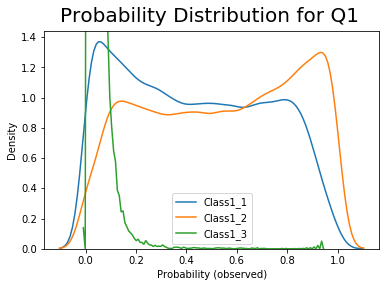

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.distplot(labels_file_to_use['Class1_1'], bins=10, hist=True)
#sns.distplot(labels_file_to_use['Class1_2'], bins=10, hist=True)
#sns.distplot(labels_file_to_use['Class1_3'], bins=10, hist=True)
dist = plt.figure(1)
sns.kdeplot(labels_file_to_use['Class1_1'])
sns.kdeplot(labels_file_to_use['Class1_2'])
sns.kdeplot(labels_file_to_use['Class1_3'])
plt.xlabel('Probability (observed)')
plt.ylabel('Density')
plt.text(-0.1,1.5,"Probability Distribution for Q1", color='Black', fontsize=20)
plt.show()
dist.savefig('proba_distrib_q1.png')

The code cell below simply generates sample sizes for our various sub-samples (training, validation and test, for each class).

In [3]:
num_train_Q1_1 = len([name for name in os.listdir("images_training_rev1/train/Q1_1") 
                 if os.path.isfile(os.path.join("images_training_rev1/train/Q1_1", name))])
num_train_Q1_2 = len([name for name in os.listdir("images_training_rev1/train/Q1_2") 
                 if os.path.isfile(os.path.join("images_training_rev1/train/Q1_2", name))])
num_train_Q1_3 = len([name for name in os.listdir("images_training_rev1/train/Q1_3") 
                 if os.path.isfile(os.path.join("images_training_rev1/train/Q1_3", name))])

num_valid_Q1_1 = len([name for name in os.listdir("images_training_rev1/valid/Q1_1") 
                 if os.path.isfile(os.path.join("images_training_rev1/valid/Q1_1", name))])
num_valid_Q1_2 = len([name for name in os.listdir("images_training_rev1/valid/Q1_2") 
                 if os.path.isfile(os.path.join("images_training_rev1/valid/Q1_2", name))])
num_valid_Q1_3 = len([name for name in os.listdir("images_training_rev1/valid/Q1_3") 
                 if os.path.isfile(os.path.join("images_training_rev1/valid/Q1_3", name))])

num_test_Q1_1 = len([name for name in os.listdir("images_training_rev1/test/Q1_1") 
                 if os.path.isfile(os.path.join("images_training_rev1/test/Q1_1", name))])
num_test_Q1_2 = len([name for name in os.listdir("images_training_rev1/test/Q1_2") 
                 if os.path.isfile(os.path.join("images_training_rev1/test/Q1_2", name))])
num_test_Q1_3 = len([name for name in os.listdir("images_training_rev1/test/Q1_3") 
                 if os.path.isfile(os.path.join("images_training_rev1/test/Q1_3", name))])

num_train = num_train_Q1_1 + num_train_Q1_2 + num_train_Q1_3
num_valid = num_valid_Q1_1 + num_valid_Q1_2 + num_valid_Q1_3
num_test = num_test_Q1_1 + num_test_Q1_2 + num_test_Q1_3
num_tot = num_train+num_valid+num_test

print('There are %d training files.' % num_train)
print('There are %d validation files.' % num_valid)
print('There are %d test files.' % num_test)
print('There are %d total files.' % num_tot)

There are 20606 training files.
There are 20360 validation files.
There are 20612 test files.
There are 61578 total files.


## Image pre-processing and augmentation

To tackle our problem, we plan to use a Convolutional Neural Network, the current gold standard for image classification.

Before training our model, we follow best practices (cf. this Keras [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) on the topic) and augment our dataset by generating random batches of modified versions of our images. The modifications include rotating the image, flipping it, zooming in, etc. It's way to get the CNN to artificially "see" the images from various angles, which helps it learn faster and better.

Given the nature of the images in our dataset, we slightly modified the parameters of the generator provided in the Keras blog. Namely, we increased:
 - the rotation range: we are looking at galaxies and there is no reason to assume they couldn't be "upside down"
 - the shifting and zooming range: as shown in the examples above, our images have a lot of dark, empty space around the galaxy and this should help the model detect and "focus" on the galaxy itself.

In [4]:
# We define our data generator, which will be used to augment our dataset before training the model
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('images_training_rev1/train/Q1_1/103626.jpg')  # we first load a single image to test our generator
x = img_to_array(img)  # we load the image as a Numpy array
x = x.reshape((1,) + x.shape)

# the .flow() command below generates batches of randomly transformed images and saves the results to the `preview/` directory
# the output of this command is shown in the project report (PDF)
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='103626', save_format='jpeg'):
    i += 1
    if i > 16:
        break  # otherwise the generator would loop indefinitely

The code cell below applies the data generator to our entire training dataset. Please note that we do <u><b>not</u></b> use the data generator on the validation and test datasets, as we want the model to classify non-processed images. The only transformation applied to the validation and test datasets is a simple rescaling to ensure that the model can run properly.

In [5]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'images_training_rev1/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') # we have 3 classes so we need the 'categorical' class mode

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'images_training_rev1/valid',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

# this is a similar generator, for test data
test_generator = test_datagen.flow_from_directory(
        'images_training_rev1/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 20606 images belonging to 3 classes.
Found 20360 images belonging to 3 classes.
Found 20612 images belonging to 3 classes.


## Our first model: a CNN from scratch

We are now ready to train our first model. We start with a simple CNN built from the ground up. We again follow best practices (see the Keras blog referenced above) and alternate our convolutional layers (with ReLU activation functions) with pooling layers. Our final, fully connnected layer, has a Softmax activation function and a size of 3 (we have 3 classes). Because we have more than 2 classes, we use the 'Categorical Cross-Entropy" loss function.

In [69]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 150, 150

epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model_a = Sequential()
model_a.add(Conv2D(32, (3, 3), input_shape=input_shape))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))

model_a.add(Conv2D(32, (3, 3)))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))

model_a.add(Conv2D(64, (3, 3)))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))

model_a.add(Flatten())
model_a.add(Dense(64))
model_a.add(Activation('relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(3))
model_a.add(Activation('softmax'))

model_a.summary()
model_a.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 64)        18496     
__________

The code cell below provides a nice visualization of our model. It requires the 'convnet_drawer' package, which can be found [here](https://github.com/yu4u/convnet-drawer).

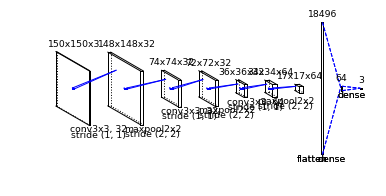

In [245]:
from convnet_drawer import Model, Conv2D, MaxPooling2D, Flatten, Dense
from pptx_util import save_model_to_pptx
from matplotlib_util import save_model_to_file

model_aa = Model(input_shape=(150, 150, 3))

model_aa.add(Conv2D(32, (3, 3)))
model_aa.add(MaxPooling2D(pool_size=(2, 2)))
model_aa.add(Conv2D(32, (3, 3)))
model_aa.add(MaxPooling2D(pool_size=(2, 2)))
model_aa.add(Conv2D(64, (3, 3)))
model_aa.add(MaxPooling2D(pool_size=(2, 2)))
model_aa.add(Flatten())
model_aa.add(Dense(64))
model_aa.add(Dense(3))

# save as svg file
model_aa.save_fig("model_aa.svg")

# save as pptx file
#save_model_to_pptx(model, "example.pptx")

# save via matplotlib
save_model_to_file(model_aa, "model_aa")


We then fit our model on our training data. We also save the weights from our model.

In [70]:
history_a = model_a.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid // batch_size)
model_a.save_weights('model_a.h5')

Epoch 1/50
1287/1287 [==============================] - 710s 552ms/step - loss: 0.6377 - acc: 0.6619 - val_loss: 0.6251 - val_acc: 0.6691
Epoch 2/50
1287/1287 [==============================] - 712s 553ms/step - loss: 0.5680 - acc: 0.7408 - val_loss: 0.5105 - val_acc: 0.7729
Epoch 3/50
1287/1287 [==============================] - 713s 554ms/step - loss: 0.5386 - acc: 0.7578 - val_loss: 0.4873 - val_acc: 0.7869
Epoch 4/50
1287/1287 [==============================] - 713s 554ms/step - loss: 0.5281 - acc: 0.7637 - val_loss: 0.4905 - val_acc: 0.7876
Epoch 5/50
1287/1287 [==============================] - 710s 552ms/step - loss: 0.5257 - acc: 0.7684 - val_loss: 0.5306 - val_acc: 0.7791
Epoch 6/50
1287/1287 [==============================] - 705s 548ms/step - loss: 0.5194 - acc: 0.7746 - val_loss: 0.4655 - val_acc: 0.8002
Epoch 7/50
1287/1287 [==============================] - 706s 549ms/step - loss: 0.5196 - acc: 0.7743 - val_loss: 0.4600 - val_acc: 0.8022
Epoch 8/50
1287/1287 [============

The code cell below then calculates the loss and accuracy of our model on our test dataset. It also plot the accuracy and loss functions over the 50 epochs. The chart shows that the model learned during the first few epochs but then started stagnating. It also shows that we are not overfitting (no divergence between the training and testing curves).

Overall, our accuracy is around 70%, which is good but could likely be improved.

[INFO] accuracy: 74.41%
[INFO] Loss: 0.5722674864331491


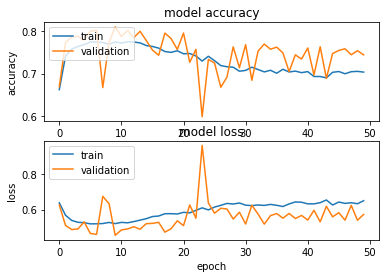

In [73]:
#loss_and_metrics = model.evaluate_generator(test_generator)
#print(loss_and_metrics)

(eval_loss_a, eval_accuracy_a) = model_a.evaluate_generator(validation_generator)
    
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy_a * 100))
print("[INFO] Loss: {}".format(eval_loss_a))

acc = plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history_a.history['acc'])
plt.plot(history_a.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history_a.history['loss'])
plt.plot(history_a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
acc.savefig('accuracy_model_a.png')

We can then generate our predictions.

In [76]:
#y_pred = model.predict_generator(test_generator)
#class_pred_a = model.predict_classes(test_generator)
prob_pred_a = model_a.predict_generator(test_generator)
#np.savetxt('class_pred_a.csv', class_pred_a, delimiter=',')
np.savetxt('prob_pred_a.csv', prob_pred_a, delimiter=',')

## Our second model: transfer learning using Xception

Our second model uses transfer learning based on the [Xception](https://arxiv.org/abs/1610.02357) model.

The first step, not shown here, was to generate the bottleneck features by training the bottom layers of Xception on our dataset. That step is described in the companion file 'bottleneck_features.py'.

The second step, shown below, is to add our own fully connected layers on top of the bottleneck features.

It is important to note that, by using transfer learning, we use the ability to augment the images like we did with our first model. Comparing the two models will then lead to a trade-off between image augmentation and transfer learning.

In [77]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'images_training_rev1/train'
valid_data_dir = 'images_training_rev1/valid'
test_data_dir = 'images_training_rev1/test'
nb_train_samples = num_train
nb_validation_samples = num_valid
nb_test_samples = num_test
epochs = 50
batch_size = 16
num_classes = len(train_generator.class_indices)

train_data = np.load('bottleneck_features_train.npy')
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_data = np.load('bottleneck_features_valid.npy')
validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)
    
test_data = np.load('bottleneck_features_test.npy')
test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

#model = Sequential()
#model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
#model.add(Dense(3, activation='softmax'))
   
model_b = Sequential()
model_b.add(Flatten(input_shape=train_data.shape[1:]))
model_b.add(Dense(256, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(3, activation='softmax'))

model_b.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 771       
Total params: 13,108,227
Trainable params: 13,108,227
Non-trainable params: 0
_________________________________________________________________


We then fit our model on our training data.

In [78]:
history_b = model_b.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

model_b.save_weights('model_b.h5')

Train on 20606 samples, validate on 20360 samples
Epoch 1/50
20606/20606 [==============================] - 284s 14ms/step - loss: 2.2158 - acc: 0.7155 - val_loss: 0.5385 - val_acc: 0.7577
Epoch 2/50
20606/20606 [==============================] - 275s 13ms/step - loss: 0.5738 - acc: 0.7740 - val_loss: 0.6024 - val_acc: 0.7846
Epoch 3/50
20606/20606 [==============================] - 273s 13ms/step - loss: 0.5449 - acc: 0.7805 - val_loss: 0.6121 - val_acc: 0.7474
Epoch 4/50
20606/20606 [==============================] - 271s 13ms/step - loss: 0.5370 - acc: 0.7847 - val_loss: 0.5294 - val_acc: 0.7970
Epoch 5/50
20606/20606 [==============================] - 269s 13ms/step - loss: 0.5342 - acc: 0.7873 - val_loss: 0.5153 - val_acc: 0.7929
Epoch 6/50
20606/20606 [==============================] - 267s 13ms/step - loss: 0.5308 - acc: 0.7912 - val_loss: 0.5188 - val_acc: 0.7929
Epoch 7/50
20606/20606 [==============================] - 266s 13ms/step - loss: 0.5361 - acc: 0.7894 - val_loss: 0.

Like we did for our first model, we calculate the loss and accuracy functions of our transfer learning model.

The chart below clearly shows that the model "learned" during the first few epochs. The accuracy is around 80%, which is 10 points higher than with our own model. Transfer learning significantly improved the performance of our model.

20360/20360 [==============================] - 15s 750us/step
[INFO] accuracy: 78.84%
[INFO] Loss: 0.7252462226992623


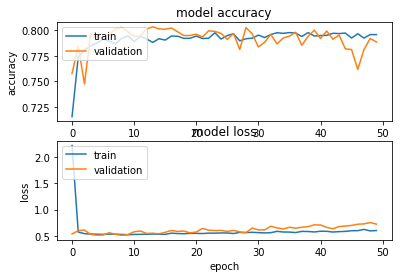

In [79]:
(eval_loss_b, eval_accuracy_b) = model_b.evaluate(validation_data, validation_labels, batch_size=batch_size, verbose=1)
    
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy_b * 100))
print("[INFO] Loss: {}".format(eval_loss_b))

acc = plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history_b.history['acc'])
plt.plot(history_b.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history_b.history['loss'])
plt.plot(history_b.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
acc.savefig('accuracy_model_b.png')

Below, we generate our predictions and save our two models for later use.

In [81]:
class_pred_b = model_b.predict_classes(test_data)
prob_pred_b = model_b.predict(test_data)
np.savetxt('class_pred_b.csv', class_pred_b, delimiter=',')
np.savetxt('prob_pred_b.csv', prob_pred_b, delimiter=',')

In [235]:
from keras.models import load_model

model_a.save('mmodel_a.h5')
model_b.save('mmodel_b.h5')

## Analysis: Benchmarking and Confusion Matrix

This next section analyses the results of our second model (with transfer learning) in more details.

We start by preparing the data for the analysis and importing the benchmark model.

One word on the benchmark model: it was provided by the Galaxy Zoo Kaggle competition. It provides predicted probabilities based on an analysis of the central pixel of the image. Given that it was the benchmark used during the competition, we use it here as well.

In [224]:
test_sample = labels_file_to_use[labels_file_to_use['random']==3]
test_labels_to_use = test_sample.iloc[:,-1]
test_labels_to_use.to_csv("test_labels_to_use.csv", index=False)

In [8]:
benchmark_file_to_use = pd.read_csv("benchmark_file_to_use.csv")
test_labels_to_use = pd.read_csv("test_labels_to_use.csv")

In [231]:
benchmark_sample = benchmark_file_to_use[benchmark_file_to_use['random']==3]
benchmark_labels_to_use = benchmark_sample.iloc[:,-1]

In [246]:
class_pred_b_to_use=[]
for row in range(0,len(class_pred_b)):
    if class_pred_b[row] == 0 :
        class_pred_b_to_use.append(1)
    elif class_pred_b[row] == 1 :
        class_pred_b_to_use.append(2)
    else: 
        class_pred_b_to_use.append(3)

The cells below calculate RMSE and accuracy. A discussion of precision and recall is provided in the report.

In [252]:
from sklearn.metrics import mean_squared_error
import math
rmse_test = math.sqrt(mean_squared_error(test_labels_to_use,class_pred_b_to_use))
rmse_benchmark = math.sqrt(mean_squared_error(test_labels_to_use,benchmark_labels_to_use))
print("The Test RMSE is: {0}".format(rmse_test))
print("The Benchmark RMSE is: {0}".format(rmse_benchmark))

The Test RMSE is: 0.6948215764448767
The Benchmark RMSE is: 0.6599784176325265


In [253]:
from sklearn.metrics import accuracy_score

accuracy_test = accuracy_score(test_labels_to_use,class_pred_b_to_use)
accuracy_benchmark = accuracy_score(test_labels_to_use,benchmark_labels_to_use)
print("The Test accuracy is: {0}".format(accuracy_test))
print("The Benchmark accuracy is: {0}".format(accuracy_benchmark))

The Test accuracy is: 0.5188239860275567
The Benchmark accuracy is: 0.5644284882592664


Finally, we build confusion matrices for our model and the benchmark. It will allow us to calculate precision and recall by class in the report.

In [254]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels_to_use, class_pred_b)

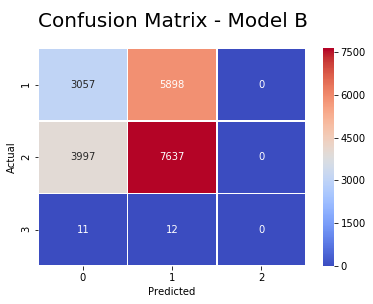

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

hm = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5, cmap="coolwarm")
plt.ylim(ymin=4, ymax=1)
plt.xlim(xmax=3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.text(0,0.7,"Confusion Matrix - Model B", color='Black', fontsize=20)
hm.get_figure().savefig('heatmap_test.png')

In [256]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels_to_use,benchmark_labels_to_use)

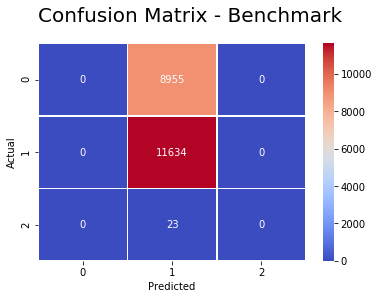

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

hm = sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5, cmap="coolwarm")
#plt.ylim(ymin=4, ymax=1)
#plt.xlim(xmax=3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.text(0,-0.3,"Confusion Matrix - Benchmark", color='Black', fontsize=20)
hm.get_figure().savefig('heatmap_benchmark.png')

## Free-Form Visualization

The code below creates the chart used in the "free form visualization".

In [4]:
from keras.models import load_model
model_b=load_model('mmodel_b.h5')

In [78]:
test_sample = labels_file_to_use[labels_file_to_use['random']==3]
probs = test_sample.iloc[:, 0:4]
probs = probs.reset_index()
probs[0:10]

index  GalaxyID  Class1_1  Class1_2  Class1_3
0      1    100023  0.327001  0.663777  0.009222
1      2    100053  0.765717  0.177352  0.056931
2      4    100090  0.933839  0.000000  0.066161
3      5    100122  0.738832  0.238159  0.023009
4     11    100157  0.330462  0.669145  0.000393
5     14    100237  0.164391  0.800759  0.034850
6     17    100288  0.645580  0.308559  0.045861
7     21    100367  0.471429  0.512708  0.015863
8     23    100382  0.256861  0.742810  0.000329
9     25    100402  0.610000  0.390000  0.000000

In [82]:
prob_pred_b = pd.read_csv("prob_pred_b.csv", header=None)
prob_pred_b = prob_pred_b.rename(index=str, columns={0: "Prob1_1", 1: "Prob1_2", 2: "Prob1_3"})
prob_pred_b = prob_pred_b.reset_index()
prob_pred_b[0:10]

index   Prob1_1       Prob1_2       Prob1_3
0     0  0.620322  3.796776e-01  8.226915e-29
1     1  0.492364  5.076357e-01  1.713634e-12
2     2  0.480894  5.191058e-01  6.867781e-12
3     3  0.625099  3.749011e-01  3.460592e-29
4     4  0.617732  3.822685e-01  4.709221e-29
5     5  0.718454  2.815456e-01  0.000000e+00
6     6  0.965817  3.418269e-02  0.000000e+00
7     7  1.000000  4.728372e-08  0.000000e+00
8     8  0.239265  7.607356e-01  0.000000e+00
9     9  0.775312  2.246884e-01  0.000000e+00

In [83]:
free_form = pd.concat([probs, prob_pred_b], axis=1)
free_form[0:10]

index  GalaxyID  Class1_1  Class1_2  Class1_3 index   Prob1_1       Prob1_2  \
0     1    100023  0.327001  0.663777  0.009222     0  0.620322  3.796776e-01   
1     2    100053  0.765717  0.177352  0.056931     1  0.492364  5.076357e-01   
2     4    100090  0.933839  0.000000  0.066161     2  0.480894  5.191058e-01   
3     5    100122  0.738832  0.238159  0.023009     3  0.625099  3.749011e-01   
4    11    100157  0.330462  0.669145  0.000393     4  0.617732  3.822685e-01   
5    14    100237  0.164391  0.800759  0.034850     5  0.718454  2.815456e-01   
6    17    100288  0.645580  0.308559  0.045861     6  0.965817  3.418269e-02   
7    21    100367  0.471429  0.512708  0.015863     7  1.000000  4.728372e-08   
8    23    100382  0.256861  0.742810  0.000329     8  0.239265  7.607356e-01   
9    25    100402  0.610000  0.390000  0.000000     9  0.775312  2.246884e-01   

        Prob1_3  
0  8.226915e-29  
1  1.713634e-12  
2  6.867781e-12  
3  3.460592e-29  
4  4.709221e-29  
5  0.000000e+00  
6  0.000000e+00  
7  0.000000e+00  
8  0.000000e+00  
9  0.000000e+00

In [84]:
len(free_form)

20612

In [85]:
free_form.to_csv("free_form.csv", index=False)

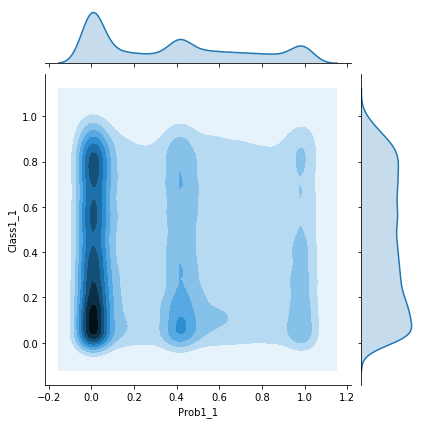

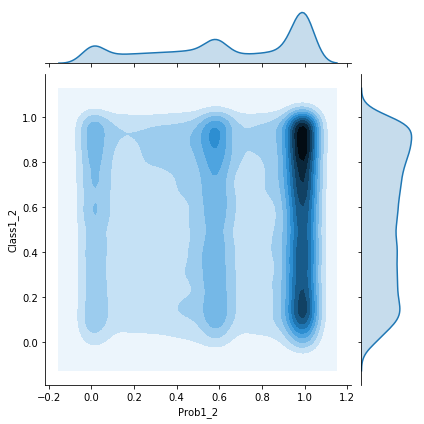

In [100]:
import seaborn as sns

sns.jointplot(x="Prob1_1", y="Class1_1", data=free_form, kind="kde", stat_func=None)
sns.jointplot(x="Prob1_2", y="Class1_2", data=free_form, kind="kde", stat_func=None)
plt.show()